In [1]:
from mxnet import nd, autograd, gluon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 1

In [2]:
def sampler(probs, shape):
    
    length = nd.prod(nd.array(shape, dtype=int)).asscalar()

    t = nd.zeros(length)
    
    for i in range(length):
        
        cum_sum = 0
        
        p = nd.random.uniform()

        for j, prob in enumerate(probs):
            
            cum_sum += prob
            
            if p < cum_sum:
                
                t[i] = j
                break
    
    return nd.reshape(t, shape)

In [3]:
sampler(nd.array([0, .1, .2, .3, .4]), (2,5,10))


[[[3. 3. 4. 4. 4. 4. 3. 4. 3. 4.]
  [4. 3. 3. 2. 4. 1. 4. 2. 3. 3.]
  [4. 4. 3. 3. 3. 3. 4. 4. 1. 3.]
  [1. 4. 1. 3. 4. 4. 4. 2. 4. 4.]
  [4. 3. 4. 4. 3. 3. 4. 4. 2. 4.]]

 [[4. 3. 2. 3. 4. 4. 3. 2. 3. 3.]
  [2. 2. 4. 4. 3. 2. 3. 2. 1. 3.]
  [4. 2. 4. 2. 4. 3. 4. 4. 4. 3.]
  [3. 4. 3. 4. 4. 1. 1. 4. 4. 4.]
  [4. 2. 2. 3. 2. 4. 3. 4. 3. 3.]]]
<NDArray 2x5x10 @cpu(0)>

## 2

In [4]:
filename = gluon.utils.download('https://www.gutenberg.org/files/84/84-0.txt')

with open(filename) as f:
    book = f.read()

print(book[0:100])

﻿
Project Gutenberg's Frankenstein, by Mary Wollstonecraft (Godwin) Shelley

This eBook is for the u


In [5]:
# split by space
book = book.split()

In [6]:
def clean(data):
    
    import re

    words = []
    
    for word in data:
        
        # if word has punctuation, skip
        if re.search(r'[^\w]', word):
            
            continue
            
        else:
            
            words.append(word.lower())
            
    return words

In [7]:
words = clean(book)

In [8]:
n = len(words)

counts = nd.zeros((5, n))
totals = nd.zeros(5)

In [9]:
lst = ['a', 'and', 'the', 'is', 'i']

for i, w in enumerate(words):
    if w in lst:
        totals[lst.index(w)] += 1
    counts[:, i] = totals

In [10]:
totals /= n

In [11]:
totals


[0.02128573 0.04445135 0.06404962 0.00481075 0.0402475 ]
<NDArray 5 @cpu(0)>

In [12]:
estimates = nd.arange(n).reshape(1, -1) + 1
estimates = counts / estimates

In [13]:
y = np.arange(1, n+1).reshape(-1, 1)

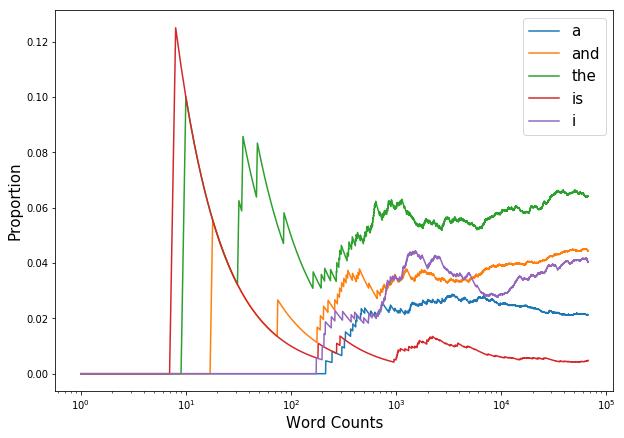

In [14]:
plt.figure(figsize=(10,7))

for i in range(5):
    plt.semilogx(y, estimates[i,:].asnumpy(), label=lst[i])
    
plt.xlabel('Word Counts', size=15)
plt.ylabel('Proportion', size=15)
plt.legend(prop={'size':15})
plt.show()

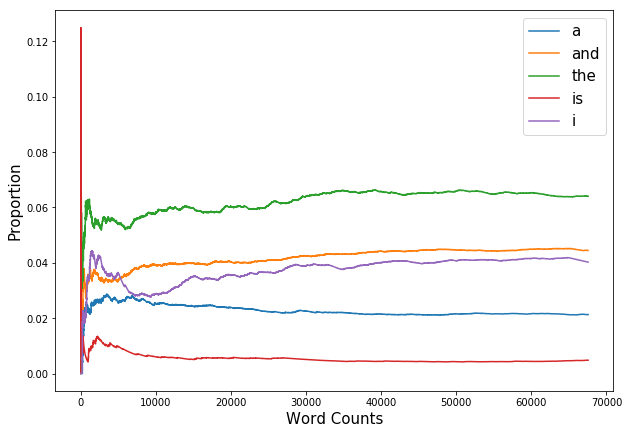

In [15]:
plt.figure(figsize=(10,7))

for i in range(5):
    plt.plot(estimates[i,:].asnumpy(), label=lst[i])
    
plt.xlabel('Word Counts', size=15)
plt.ylabel('Proportion', size=15)
plt.legend(prop={'size':15})
plt.show()

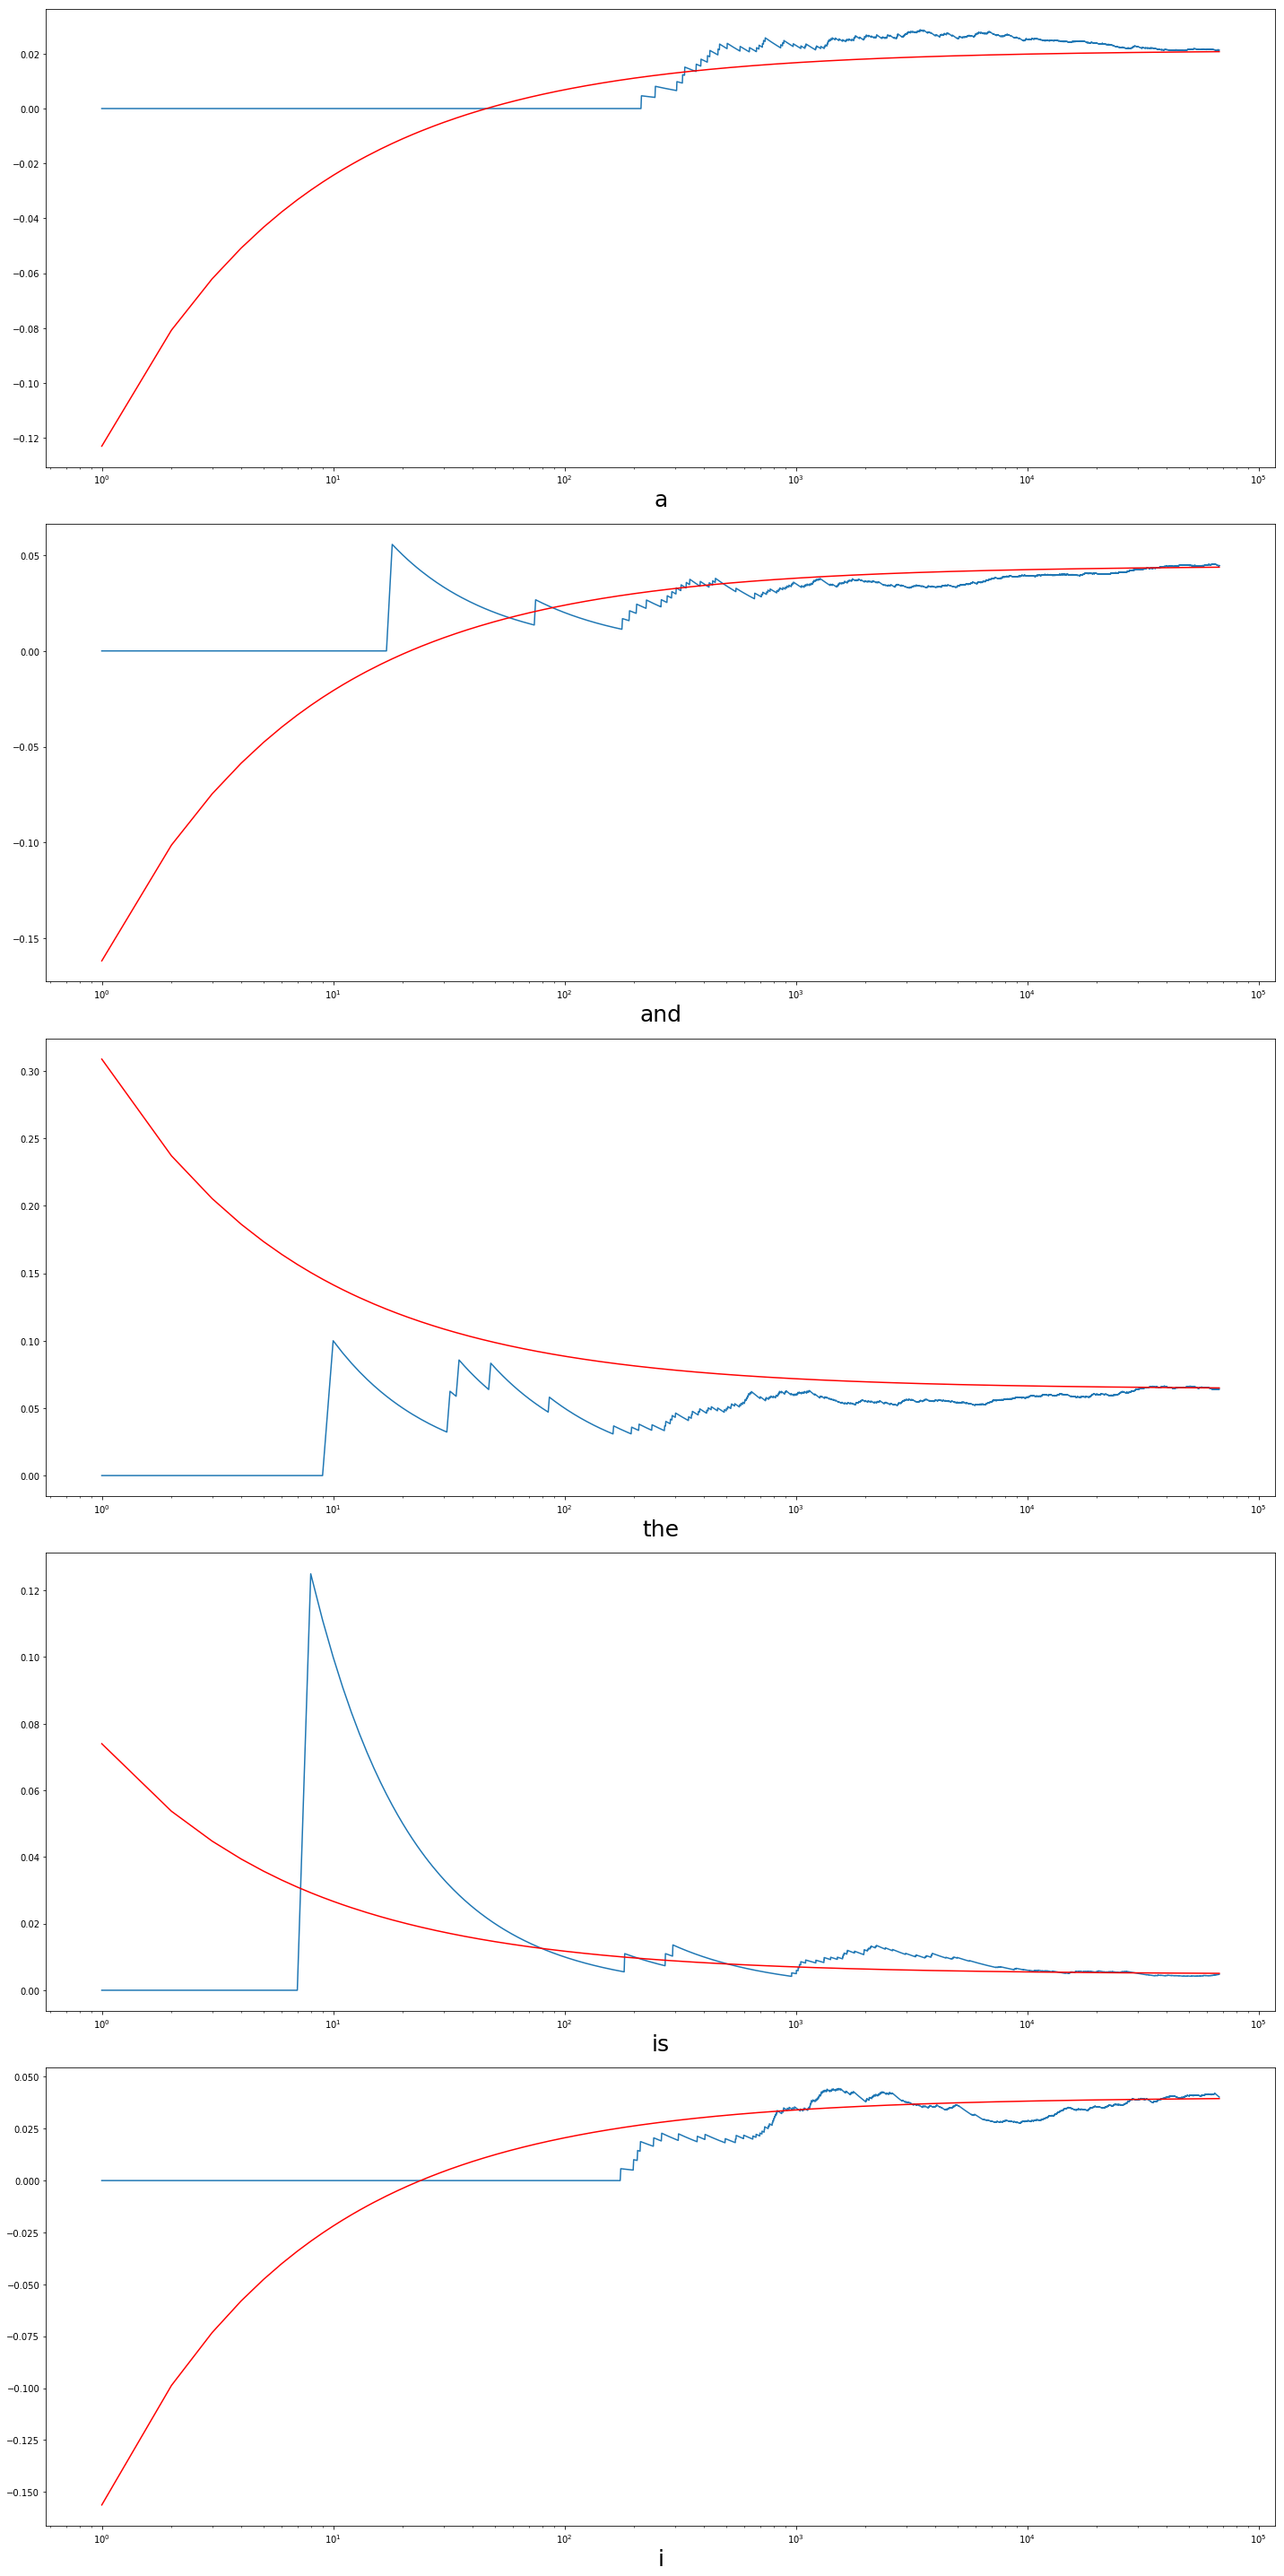

In [16]:
mean = .0235
variance = .005
y = np.arange(1,n+1).reshape(-1,1)

fig, ax = plt.subplots(5, 1, figsize=(20, 40))
mean = totals.asnumpy()
variance = mean - mean **2


for i in range(5):
    ax[i].semilogx(y, estimates[i, :].asnumpy())
    if i in [2, 3]:
        ax[i].semilogx(y, (variance[i]**0.5) * np.power(y,-0.5) + mean[i],'r')
    else:
        ax[i].semilogx(y, -(variance[i]**0.5) * np.power(y,-0.5) + mean[i],'r')
    ax[i].set_xlabel(lst[i], size=25)

fig.tight_layout()
plt.show();

We cannot use CLT on this problem directly since all the probabilites of each word are not equal that they don't converge to one point. To make CLT happen, the fequencies of them should be equal. However, we can still apply them here on <b>each</b> word that as the number counts (total words counts) increase, each of their probabilities converge to one point.

## 3

1. $\frac{\partial \bf y}{\partial \bf x} = \frac{\partial \bf y}{\partial \bf u}\frac{\partial \bf u}{\partial \bf x}$
2. $\frac{\partial z}{\partial \bf w} = 2X^TXw - 2X^Ty$

## 4

In [17]:
def log_exp(x, y):
    
    return - nd.log(nd.exp(x) / (nd.exp(x) + nd.exp(y)))

In [18]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[1.3132617]
<NDArray 1 @cpu(0)>

In [19]:
def grad(forward_func, x, y):

    x.attach_grad()
    y.attach_grad()
    
    with autograd.record():
        
        z = forward_func(x, y)
        
    z.backward()
    
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)

grad(log_exp, x, y)

x.grad = 
[-0.7310586]
<NDArray 1 @cpu(0)>
y.grad = 
[0.7310586]
<NDArray 1 @cpu(0)>


In [20]:
x, y = nd.array([50]), nd.array([100])

grad(log_exp, x, y)

x.grad = 
[nan]
<NDArray 1 @cpu(0)>
y.grad = 
[nan]
<NDArray 1 @cpu(0)>


As we can see from the above print, exponential of y is too big to fit into the memory resulting in too large and infinity values. Because it cannot fit, the grad of the functions will return weird value (or nan) values. <br>
As covered in the lecture slides, we can put data into mantissa instead of exponents to avoid this problem.

In [21]:
def stable_log_exp(x, y):
    
    a = nd.array([max(x.asscalar(), y.asscalar())])

    denom = a + nd.log(nd.exp(x - a) + nd.exp(y - a))
    
    return -1 * nd.log(nd.exp(x) / denom)

stable_log_exp(nd.array([50]), nd.array([100]))


[-45.39483]
<NDArray 1 @cpu(0)>

In [22]:
grad(stable_log_exp, x, y)

x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[0.01]
<NDArray 1 @cpu(0)>
